Classification sur la variable "Satisfaction" :
1. Compléter l'analyse exploratoire de la question 1 en se focalisant sur les relations des différentes variables avec la variable cible.

2.  Prétraiter les données : choisir les variables explicatives (essayer plusieurs sélections), procéder à l'imputation des valeurs manquantes (tester plusieurs stratégies), normaliser les variables, etc.

3.  Appliquer les différents algorithmes étudiés en cours. Pour chacun d'eux on procèdera ainsi : définition d'un dictionnaire d'hyperparamètres, recherche exhaustive (ou aléatoire) des meilleurs hyperparamètres, établissement de la matrice de confusion, calculs des différentes métriques (exactitude, précision, rappel, F1 score, auc, etc.).

4. Comparer les différents algorithmes.

In [1]:
# Imports

from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, StandardScaler
import seaborn as sns
import joblib
import math
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
# from sklearn.neighbors import KNeighborsRegressor, DecisionTreeRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt

# Chargement du dataset

X_train = pd.read_csv("satisfaction_X_train_clean.csv")
y_train = pd.read_csv("satisfaction_y_train.csv")
X_test = pd.read_csv("satisfaction_X_test_clean.csv")
y_test = pd.read_csv("satisfaction_y_test.csv")

print("🚀 ~ X_train:")
print(X_train.shape)
print("null_values:", X_train.isnull().values.sum())
# print(X_train.head)

print("🚀 ~ y_train:")
print(y_train.shape)
print("null_values:", y_train.isnull().values.sum())
# print(y_train.head)

print("🚀 ~ X_test:")
print(X_test.shape)
print("null_values:", X_test.isnull().values.sum())
# print("null_values:", X_test.isnull().sum())

# print(X_test.head)

print("🚀 ~ y_test:")
print(y_test.shape)
print("null_values:", y_test.isnull().values.sum())
# print("null_values:", X_test.isnull().sum())

# print(y_test.head)


🚀 ~ X_train:
(103904, 22)
null_values: 0
🚀 ~ y_train:
(103904, 1)
null_values: 0
🚀 ~ X_test:
(25976, 22)
null_values: 0
🚀 ~ y_test:
(25976, 1)
null_values: 0


### 1. Compléter l'analyse exploratoire de la question 1 en se focalisant sur les relations des différentes variables avec la variable cible.

In [2]:
X = pd.concat([X_train, X_test], ignore_index=True)
y = pd.concat([y_train, y_test], ignore_index=True)
y.rename(columns={'0': 'satisfaction'}, inplace=True)

df= pd.concat([X, y], axis=1)

print(df.dtypes)

Class                                float64
Gender                                 int64
Customer Type                          int64
Type of Travel                         int64
Flight Distance                      float64
Departure Delay in Minutes           float64
Arrival Delay in Minutes             float64
Departure/Arrival time convenient    float64
Food and drink                       float64
Inflight entertainment               float64
Age                                  float64
Inflight wifi service                float64
Ease of Online booking               float64
Gate location                        float64
Online boarding                      float64
Seat comfort                         float64
Cleanliness                          float64
Leg room service                     float64
On-board service                       int64
Baggage handling                       int64
Checkin service                        int64
Inflight service                       int64
satisfacti

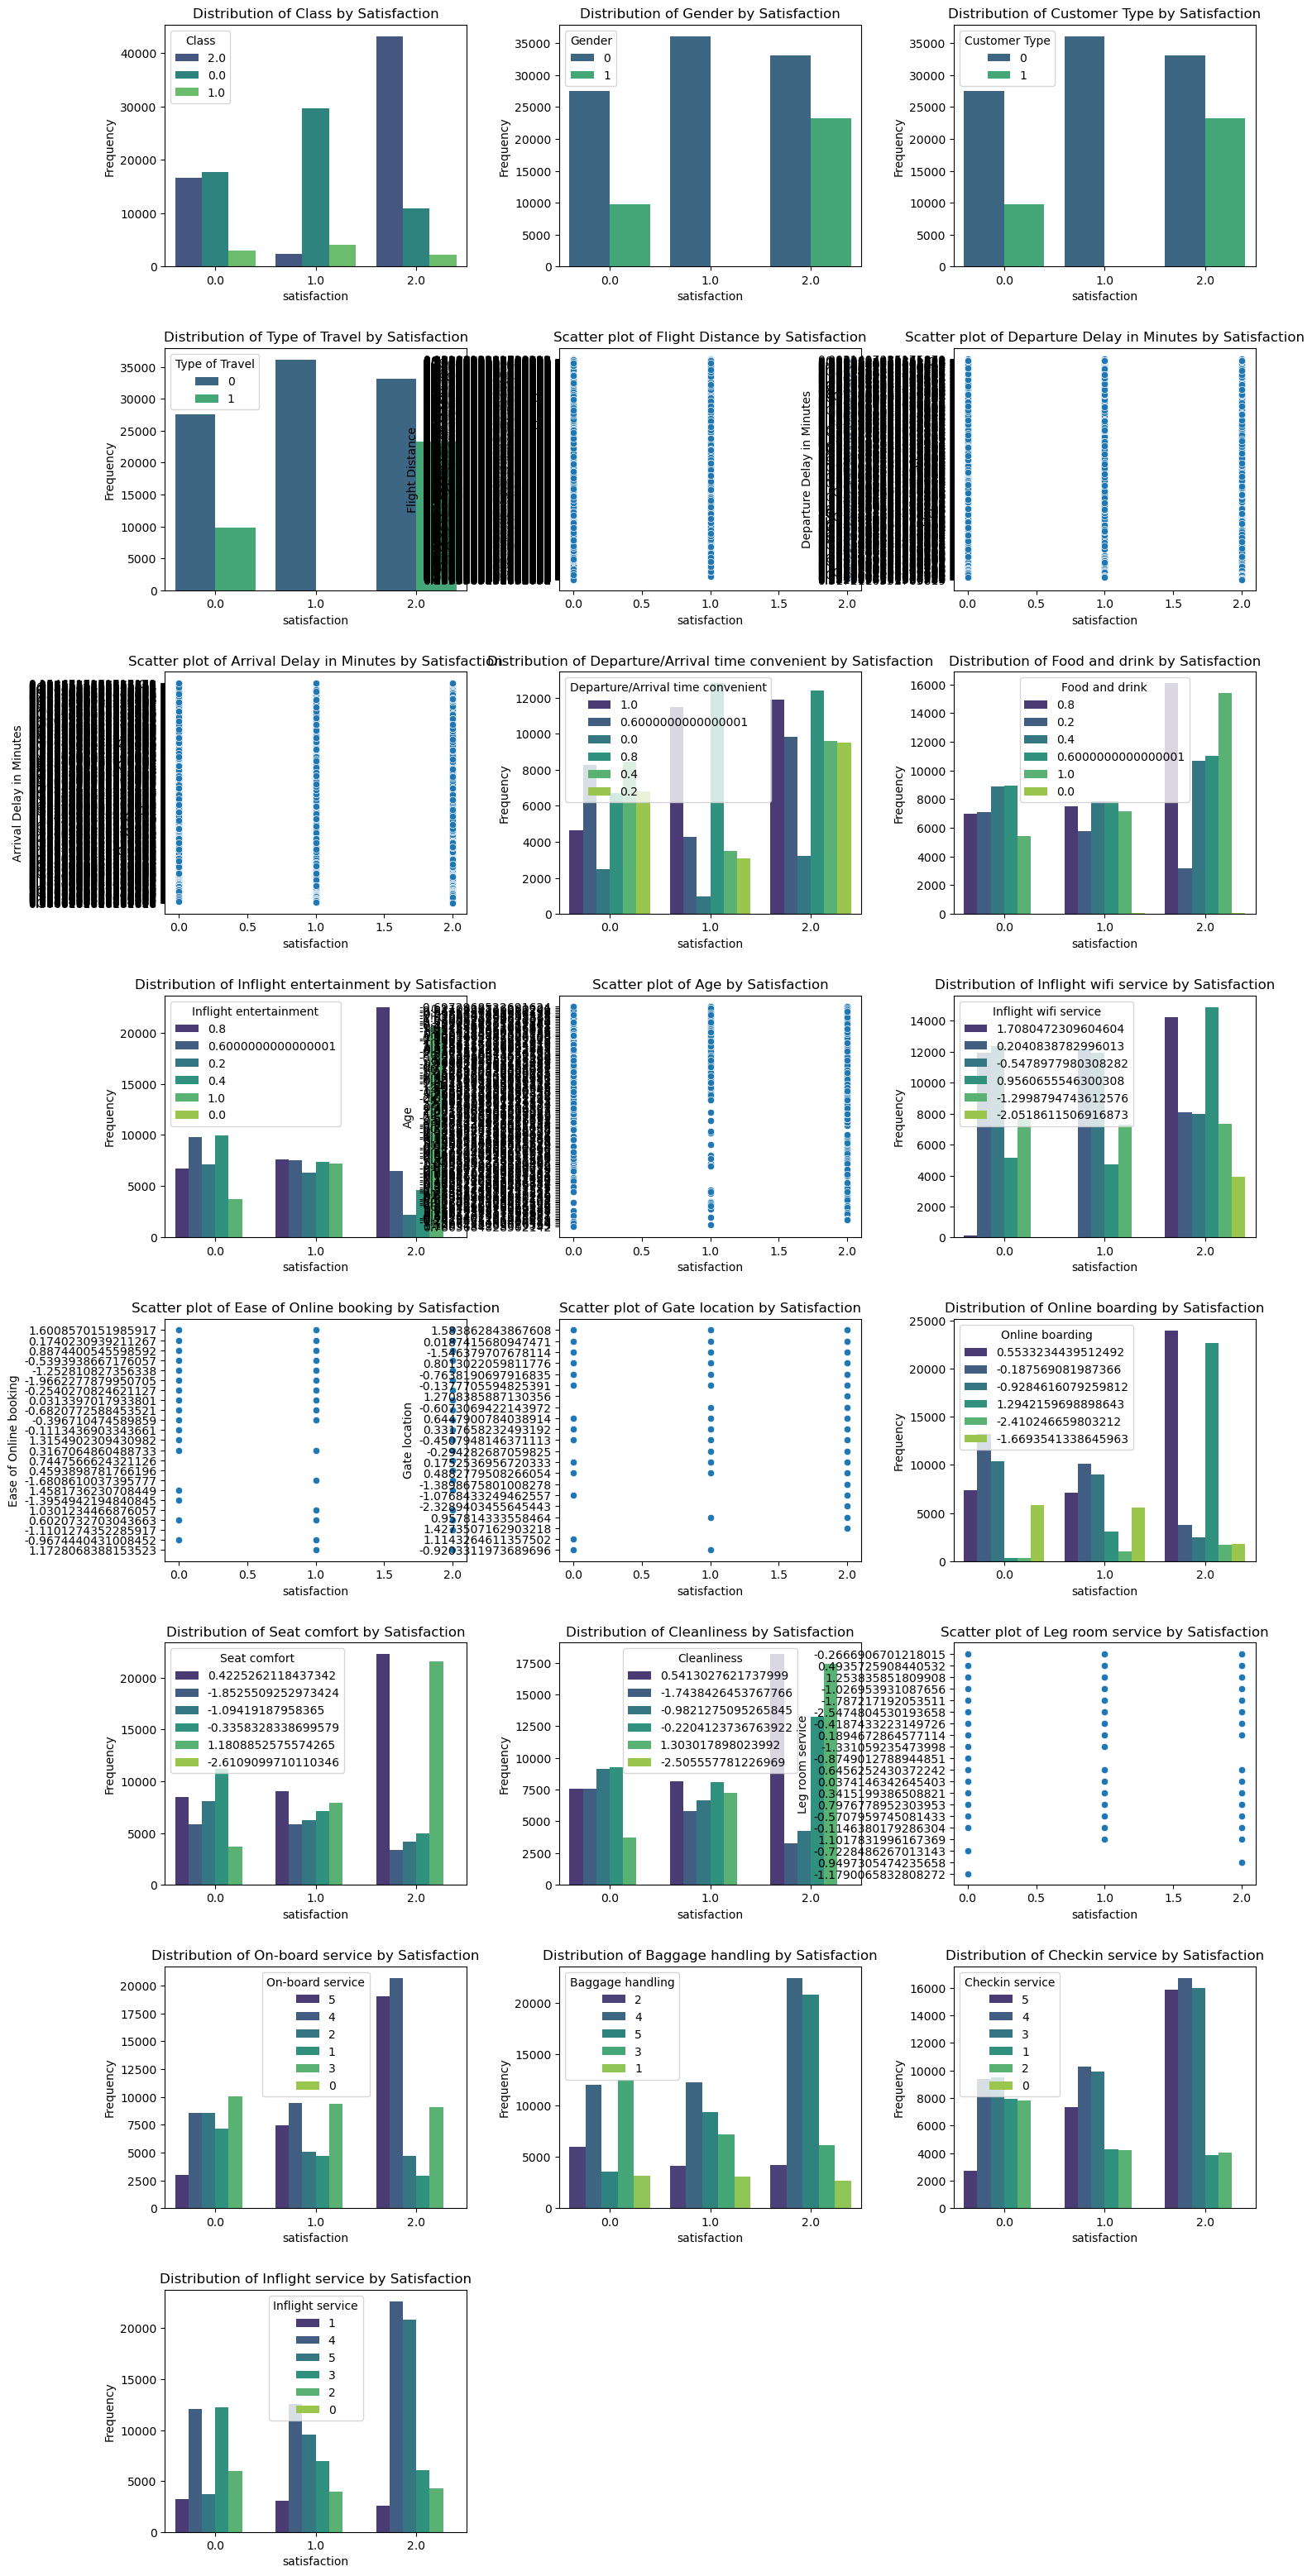

In [3]:
explicative_variables = df.columns[df.columns != 'satisfaction']
# Configuration de la grille de graphiques
n_cols = 3  # Nombre de graphiques par ligne
n_rows = (len(explicative_variables) + 2) // n_cols  # Calculer le nombre de lignes nécessaires

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 5, n_rows * 4))
fig.tight_layout(pad=5.0)  # Ajuster l'espacement entre les graphiques

# Création des graphiques
for i, var in enumerate(explicative_variables):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    # Convertir la variable en string si c'est numérique
    if df[var].dtype != 'object':
        df[var] = df[var].astype(str)
    if len(df[var].unique()) < 10:
        # Utilisation de countplot pour les données catégorielles
        sns.countplot(ax=ax, data=df, x='satisfaction', hue=var, palette='viridis')
        ax.set_title(f'Distribution of {var} by Satisfaction')
        ax.set_ylabel('Frequency')
    else:
        # Utilisation de scatterplot pour les données numériques
        sns.scatterplot(ax=ax, data=df, x='satisfaction', y=var)
        ax.set_title(f'Scatter plot of {var} by Satisfaction')

# Cacher les graphiques vides s'il y en a
for j in range(i + 1, n_rows * n_cols):
    if j // n_cols < n_rows and j % n_cols < n_cols:
        axes[j // n_cols][j % n_cols].axis('off')

plt.show()

Interprétation?

### 3.  Appliquer les différents algorithmes étudiés en cours. Pour chacun d'eux on procèdera ainsi : définition d'un dictionnaire d'hyperparamètres, recherche exhaustive (ou aléatoire) des meilleurs hyperparamètres, établissement de la matrice de confusion, calculs des différentes métriques (exactitude, précision, rappel, F1 score, auc, etc.). -> Classification multi

Doc: https://scikit-learn.org/stable/modules/multiclass.html

In [4]:
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


# Définition des modèles pour le VotingClassifier
log_clf = LogisticRegression(solver='liblinear', random_state=42, max_iter=1000)
tree_clf = DecisionTreeClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)

# VotingClassifier & AdaBoostClassifier
estimators = [
    ('lr', log_clf), 
    ('tree', tree_clf), 
    ('svc', svm_clf)
]

# GaussianNB
delta = 5*1e-10
var_smoothing_start = 1e-9 - delta
var_smoothing_end = 1e-9 + delta
var_smoothing_step = 1e-11

# LDA
start_shrinkage = 0.1
end_shrinkage = 0.3
step_shrinkage = 0.001


# * Définition du dictionnaire d'hyperparamètres
models_dict = [
               {
                  "type": KNeighborsClassifier(), 
                  "hyperparameters" : []
                  },
            # Trop long
               # {
               #    "type": KNeighborsClassifier(), 
               #    "hyperparameters" : [
               #       {
               #          #   "n_neighbors" : [3, 5, 10],
               #            "weights"     : ["uniform", "distance"],
               #            "algorithm"   : ["ball_tree", "kd_tree"],
               #          #   "p"           : [2, 4, 6],
               #        }
               #      ]
               #  },
               {"type": DecisionTreeClassifier(), "hyperparameters" : []},
               {
                  "type": DecisionTreeClassifier(), 
                  "hyperparameters" : [
                     {
                        'criterion': ['gini', 'entropy'],
                        'max_depth': [3, 5, 10],
                      }
                    ]
                },
               {"type": GaussianNB(), "hyperparameters" : []},
               {
                  "type": GaussianNB(), 
                  "hyperparameters" : [
                     {
                        "var_smoothing" : np.arange(var_smoothing_start, var_smoothing_end, var_smoothing_step)
                      }
                  ]
               },
               {"type": LinearSVC(multi_class="crammer_singer", max_iter=2000), "hyperparameters" : []},
               {"type": LogisticRegression(multi_class="multinomial", max_iter=1000), "hyperparameters" : []},
               {"type": RandomForestClassifier(), "hyperparameters" : []},  
               {
                  "type": VotingClassifier(estimators=estimators, voting='hard'), 
                  "hyperparameters" : [
                     {
                      'lr__C': [0.1, 1.0, 10.0],
                      'tree__criterion': ['gini', 'entropy'],
                      'tree__max_depth': [3, 4, 5],
                      'svc__C': [0.1, 1.0, 10.0],
                      'svc__gamma': ['scale', 'auto'],
                    }
                  ]
                },  
               {
                  "type": AdaBoostClassifier(), 
                  "hyperparameters" : [
                     {
                        "n_estimators" : [50, 100, 200],
                        "learning_rate": [0.1, 1, 10]
                     }
                  ]
               },
               {"type": GradientBoostingClassifier(), "hyperparameters" : []},
               {
                     "type": GradientBoostingClassifier(), 
                     "hyperparameters" : [
                        {
                           "n_estimators" : [50, 100, 200],
                           "learning_rate": [0.1, 1, 10],
                           "criterion": ["friedman_mse", "squared_error"],
                           "max_depth": [3, 5, 10]
                        }
                     ]
                  },
               {"type": LinearDiscriminantAnalysis(), "hyperparameters" : []},
               {
                  "type": LinearDiscriminantAnalysis(), 
                  "hyperparameters" : [
                     {
                        "solver" : ["lsqr", "eigen"],
                        "shrinkage": np.arange(start_shrinkage, end_shrinkage, step=step_shrinkage),
                     },
                     {
                        "solver" : ["svd"],
                     }
                  ]
               },            
              ]

# Initialiser le dictionnaire pour les scores
model_scores = {}

for index, model in enumerate(models_dict):
    classifier = model["type"]
    best_params = {}
    model_name=f"{type(classifier).__name__}"
    print("Calculating: ", index)

    if model["hyperparameters"] == []:
      # * Essai avec le modèle pur
      classifier.fit(X_train.values, y_train.values.ravel())
      y_pred = classifier.predict(X_test.values)
    else:
      # * Recherche des meilleurs hyperparamètres
      model_name += "_gscv"
      hyperparameters = model["hyperparameters"]
      gscv_model = GridSearchCV(
      estimator = classifier,
      param_grid = hyperparameters,
      cv = 5,
      scoring = "f1_weighted")
      gscv_model.fit(X_train.values, y_train.values.ravel())
      y_pred = gscv_model.predict(X_test.values)
      best_params = gscv_model.best_params_
      
    # Calcul des métriques
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    
    # Stocker les métriques
    model_scores[model_name] = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "confusion_matrix": cm,
        "best_params": best_params
    }



Calculating:  0


Calculating:  1
Calculating:  2
Calculating:  3
Calculating:  4
Calculating:  5


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Calculating:  6


In [ ]:
for model in model_scores:
  print("Name: ", model.key())
  print("--> best_params: ", model.best_params)
  print("--> accuracy: ", model.accuracy)
  print("--> precision: ", model.precision)
  print("--> recall: ", model.recall)
  print("--> f1_score: ", model.f1_score)
  print("--> confusion_matrix: ", model.confusion_matrix)
  print("---------------------------------------")

### 4. Comparer les différents algorithmes.

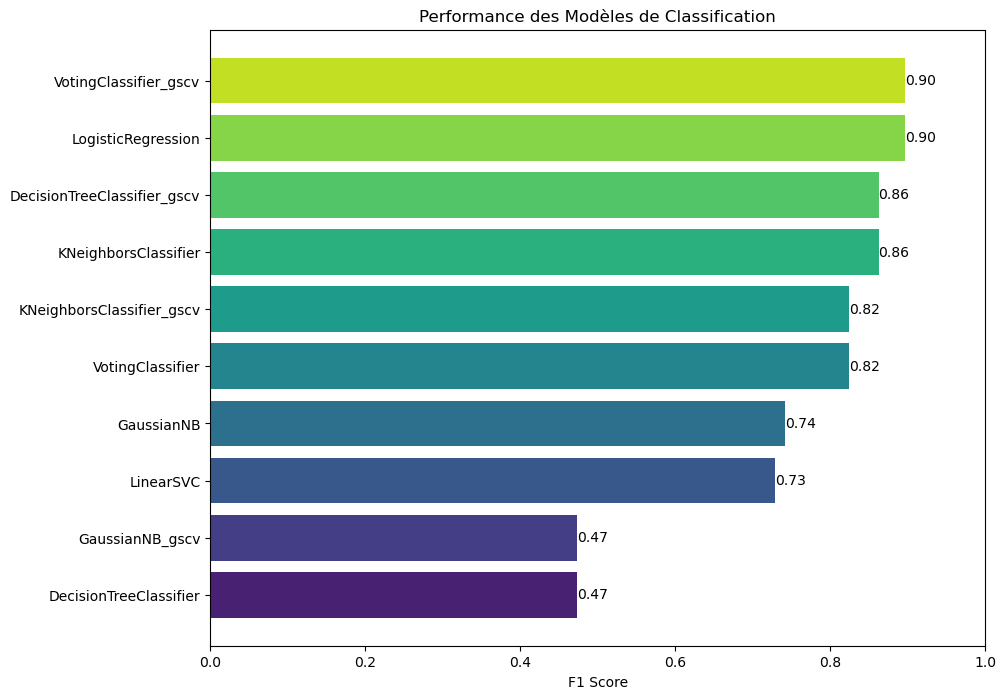

In [ ]:
# Tri du dictionnaire par score F1
sorted_scores = dict(sorted(model_scores.items(), key=lambda item: item[1]))

colors = sns.color_palette('viridis', len(sorted_scores))

# Tracer le graphique
plt.figure(figsize=(10, 8))
bars = plt.barh(list(sorted_scores.keys()), list(sorted_scores.values()), color=colors)
plt.xlabel('F1 Score')
plt.title('Performance des Modèles de Classification')
plt.xlim(0, 1)  # Limiter l'axe des x pour mieux visualiser les scores F1

# Ajouter les valeurs exactes sur les barres
for bar in bars:
    plt.text(bar.get_width(),  # Position horizontale, un peu à droite de la fin de la barre
             bar.get_y() + bar.get_height() / 2,  # Position verticale, au centre de la barre
             f'{bar.get_width():.2f}',  # Texte avec 2 décimales
             va='center',  # Alignement vertical au centre
             ha='left')  # Alignement horizontal à gauche pour que le texte suive la barre

plt.show()
